# RQ2: How does the variation in time zones from where developers collaborate influence the speed of code review?

## A. Repository-Level Analysis:
### 1. Statistical analysis of the average pairwise difference
In the below:
- We read the preprocessed data from the corresponding file
- Plot a scatter plot of the data to visually examine the relationship between the independent and dependent variables. This step can help us identify any potential patterns or outliers.
- Perform the Shapiro Wilk & QQ-plot tests for normal distribution (and visualize) on our dependent variable
- Perform the Mann-Whitney U test to see if there is any significant difference between repositories of low average difference and high average difference. to do this we set a threshold, after plotting a frequency histogram.

We find out:
- From the scatter plot, we can see that the relationship of our data is not linear.
- That our dependent variable does not follow a ND. This is because the p-value of the Shapiro Wilk test is not higher than 0.05 so we accept the null hypothesis (i.e., that the data are not normally distributed). 
- We also see a visualization of the non-normality in the QQ-plot. If the time-to-merge was a ND variable, then the data point would have followed the straight diagonal line. Deviation from the straight line suggests a departure from the expected distribution. In our case, that the data deviate upward from the line, it indicates that the observed data has heavier tails or is more spread out than the theoretical distribution.
- Mann-Whitney U test showed that there is a statistical significance between the two groups. This means that the time-to-merge of repositories with low (<4 hours) average pairwise difference is different from the time-to-merge of the repositories with high (>=4 hours) timezone difference.

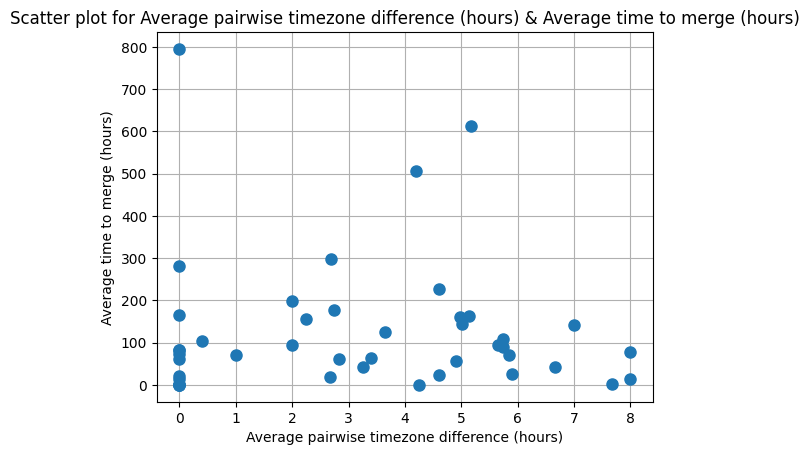

Average time to merge (hours) does not follow a normal distribution (p value = 2.2786927900142473e-08 < 0.05)


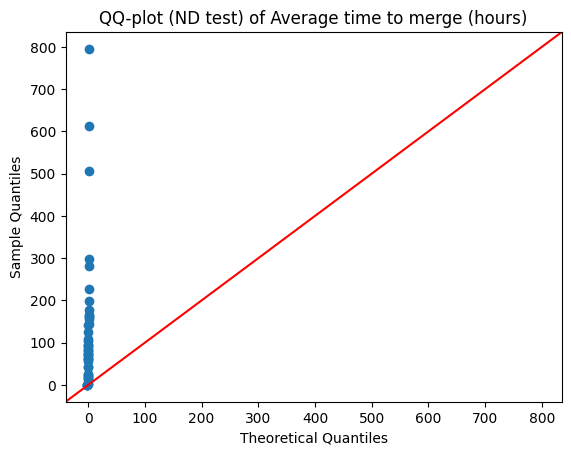

Spearman correlation: 0.08011543864702679
P-value: 0.6051847221056774
There is no statistically significant association between the average difference between timezones and the 75th percentile of time to merge.


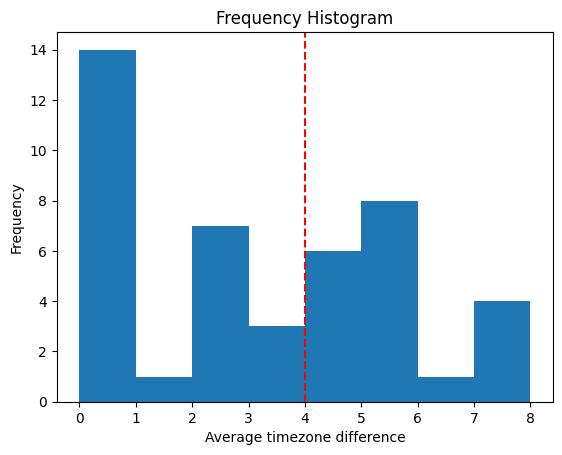

U-statistic: 174.0
P-value: 3.294539315699322e-11
The difference between the two metrics is statistically significant.


In [5]:
# READ DATA FROM PROCESSED DATASET
import json
import pendulum
import matplotlib.pyplot as plt
from scipy import stats

def tz_diff(city1, city2, on=None):
    """
    Returns the difference in hours between the time zone of city1 and city2.

    As not all time zones are separated by an integer number of hours, this
    function returns a float.

    As time zones are political entities, their definitions can change over time.
    This is complicated by the fact that daylight savings time does not start
    and end on the same days uniformly across the globe. This means that there are
    certain days of the year when the returned value between `Europe/Berlin` and
    `America/New_York` is _not_ `6.0`.

    By default, this function always assumes that you want the current
    definition. If you prefer to specify, set `on` to the date of your choice.
    It should be a `Pendulum` object.

    This function returns the number of hours which must be added to the city1 time
    in order to get the city2 time. For example,
    ```python
    >>> tz_diff('Europe/Berlin', 'America/New_York')
    -6.0
    >>> tz_diff('Europe/Berlin', 'Asia/Kabul')
    2.5
    ```
    """
    if on is None:
        on = pendulum.today()
    diff = (on.set(tz=city1) - on.set(tz=city2)).total_hours()

    # what about the diff from Tokyo to Honolulu? Right now the result is -19.0
    # it should be 5.0; Honolulu is naturally east of Tokyo, just not so around
    # the date line
    if abs(diff) > 12.0:
        if diff < 0.0:
            diff += 24.0
        else:
            diff -= 24.0
    return diff

# Opening JSON file
f = open('data_rq1/RQ1_2_Locations_PR.json')
data = json.load(f)
# x values is the indpendent (timezone difference), y are the dependent (time to merge)
x_values=[]
y_values=[]
for repo in data:
	# get average tz difference (PAIRWISE!)
    locations=repo["locations"]
    tz_sum=0
    pairs_count=0
    for i in range(len(locations)):
        for j in range(i+1, len(locations)):
            tz_sum+=abs(tz_diff(locations[i], locations[j]))
            pairs_count+=1
    if pairs_count!=0: # (avoid div by 0)
        x_values.append(tz_sum/pairs_count)
    elif len(locations) == 1: #only 1 user has locaiton available
        x_values.append(0)
    # get average time-to-merge
    y_values.append(repo["time_to_merge_average"])

def create_dot_plot(x_values, y_values, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.plot(x_values, y_values, 'o', markersize=8)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    plt.title(f'Scatter plot for {xlabel} & {ylabel}')
    plt.show()
x_label='Average pairwise timezone difference (hours)'
y_label = 'Average time to merge (hours)'
create_dot_plot(x_values, y_values, x_label, y_label)


# Closing file
f.close()


# CHECK IF THE DEPENDENT VARIABLE IS NORMALLY DISTRIBUTED
# SHAPIRO-WILK TEST
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats

def test_ShapiroWilk(values, label):
    res = shapiro(values)
    if res.pvalue>0.05: # if true, then normal distibution
        print(f'{label} follows a normal distribution (p value = {res.pvalue} > 0.05)')
    else:
        print(f'{label} does not follow a normal distribution (p value = {res.pvalue} < 0.05)')

test_ShapiroWilk(y_values, y_label)

# QQ-PLOT
import statsmodels.api as sm
import pylab
import numpy as np
def get_QQPlot(values, label):
    values=np.array(values) # data need to be in an array
    sm.qqplot(values, line='45')
    pylab.title(f'QQ-plot (ND test) of {label}')
    pylab.show()

get_QQPlot(y_values, y_label)

# Perform Spearman rank correlation test
def get_Spearman (a, b):
    correlation, p_value = stats.spearmanr(a, b)
    print(f'Spearman correlation: {correlation}')
    print(f'P-value: {p_value}')

    # Interpret the results
    if p_value < 0.05:
        print("There is a statistically significant association between the average difference between timezones and the 75th percentile of time to merge.")
    else:
        print("There is no statistically significant association between the average difference between timezones and the 75th percentile of time to merge.")
get_Spearman(x_values, y_values)


# MANN-WITNEY U TEST: 
# histogram of differences to set a threshold
import math
bin_size=1
plt.hist(x_values, bins=range(0, math.ceil(max(x_values))+bin_size, bin_size)) # get bins of size 'bin_size'
plt.gca().set(title='Frequency Histogram', xlabel= 'Average timezone difference', ylabel='Frequency')

# vertical line for threshold (<= and > 4 hours)
# Add a vertical line at a specific x-coordinate
line_position = 4  # x-coordinate where the line should be placed
plt.axvline(x=line_position, color='r', linestyle='--')
plt.show()

# MANN-WHITNEY U TEST: 
u_stat, p_value = stats.mannwhitneyu(x_values, y_values)

print(f'U-statistic: {u_stat}')
print(f'P-value: {p_value}')

# Check if the result is statistically significant
if p_value < 0.05:
    print("The difference between the two metrics is statistically significant.")
else:
    print("No significant difference between the two metrics.")


### 2. Statistical analysis of 75th percentile of time-to-merge

In the below:
- We compute for the 75th percentile of the time-to-merge to avoid outliers that lie above the 25% percent.
- Scatter plot to examine the relationship of the 75th percentile and the average timezone difference.
- Test the normality of the above measure
- Spearman correlation between the average difference in timezones in each repository & the 75 percentile of time to merge.

We find:
- Non-normally distributed
- No significant association

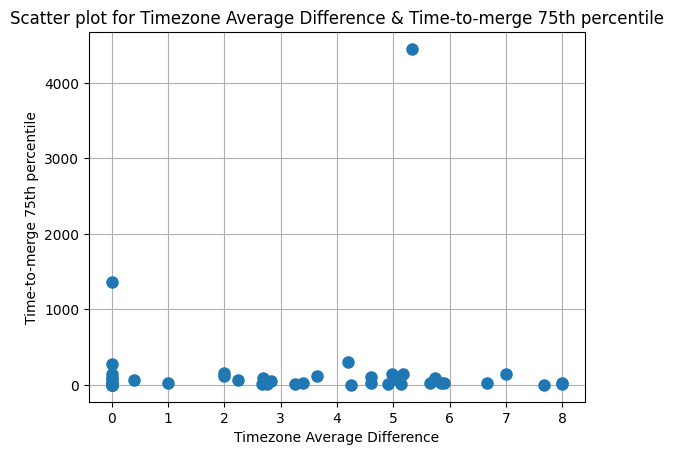

Time-to-merge 75th percentile does not follow a normal distribution (p value = 6.367505806480211e-14 < 0.05)


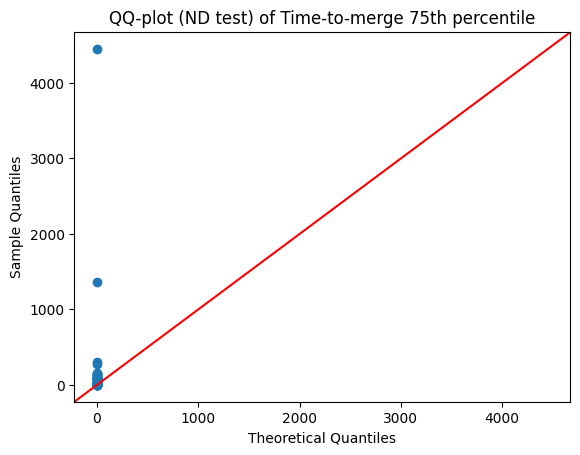

Spearman correlation: 0.10529376459418421
P-value: 0.48616379913273455
There is no statistically significant association between the average difference between timezones and the 75th percentile of time to merge.


In [37]:
import numpy as np
from scipy import stats

# READ AGAIN THE DATA
# to get all times-to-merge for each repo, and not only the average

# Simulated data: list of lists where each sublist represents 'time to merge' in hours for pull requests in one repository
# time_to_merge_data = [
#     [1, 2, 3, 4, 5],  # Repository 1
#     [2, 3, 4, 5, 6],  # Repository 2
#     [1, 3, 5, 7, 9],  # Repository 3
#     [2, 4, 6, 8, 10], # Repository 4
#     [1, 2, 2, 3, 3]   # Repository 5
# ]
time_to_merge_data=[]

for repo in data:
    time_to_merge_data.append(repo["time_to_merge"])

# CALCULATE THE 75TH PERCENTILE of TIME-TO-MERGE FOR EACH REPO
time_to_merge_75th = [np.percentile(data, 75) for data in time_to_merge_data]

# CREATE DOT PLOT
create_dot_plot(x_values, time_to_merge_75th, 'Timezone Average Difference', 'Time-to-merge 75th percentile')

# CHECK NORMALITY & VISUALIZE
test_ShapiroWilk(time_to_merge_75th, 'Time-to-merge 75th percentile')
get_QQPlot(time_to_merge_75th, 'Time-to-merge 75th percentile') #TODO: why less data here?


# Corresponding number of average time zone difference
timezones = x_values # Metric 1

get_Spearman(timezones, time_to_merge_75th)


## B. Pull Request-Level Analysis:

In this section, we perform the same steps as above, but instead of doing it in a repository-level, we perform it in a pull request level. Thus, instead of calculating the number of distinct timezones in a repository and the average time-to-merge in the repository, we are calculating the number of timezones of the people that were involved (author, reviewer, commenter) in a PR and the exact time-to-merge of that PR. <br><br>
**Before running this script, make sure to run pr_level_analysis.ipynb, which collects and preprocesses the data for this purpose**


### 1. Retrieve timezone difference from PR data

In this code, we process the data from pr_participation.json from the data directory. Here we measure our data only by pull request, not the repository. 
In the script below, we convert all collaborator locations to their respective UTC timezone. We then retrieve the timezone difference for each pull request.

In [1]:
import pytz
from datetime import datetime, timezone
import json

f = open("data/pr_participation_filtered.json")
location_data = json.load(f)

# Initialize the output dictionary
output_data = []

for item in location_data:
    repo_name = item['repository']
    participants_timezones = {}
    timezone_offsets = []
    for location, count in item['participants_timezones'].items():
        try:
            tz_obj = pytz.timezone(location)
            utc_offset = tz_obj.utcoffset(datetime.now()).total_seconds() // 3600
            timezone_offsets.append(utc_offset)
            tz_offset_str = f"UTC+{abs(utc_offset)}"
            participants_timezones[tz_offset_str] = count
        except pytz.exceptions.UnknownTimeZoneError:
            print(f"Unknown timezone: {location}")

    timezone_diff = max(timezone_offsets) - min(timezone_offsets) if len(timezone_offsets) > 1 else 0

    output_data.append({
        "repository": repo_name,
        "participants_timezones": participants_timezones,
        "time_to_merge": item["time_to_merge"],
        "timezone_diff": timezone_diff
    })

with open("data_rq1/RQ2_pr_participation_timezones.json", "w") as outfile:
    json.dump(output_data, outfile)

print("Result written in data_rq1/RQ2_pr_participation_timezones.json")

Result written in data_rq1/RQ2_pr_participation_timezones.json


### 2. Statistical analysis for pull requests and timezone 


1. We perform a Shapiro-Wilks test to check for normal distribution of the data. The findings show that our data is not normally distributed.
2. We perform a Mann-Whitney U test. 
   - This test is performed on the time to merge and timezone difference of each pull request.
   - The p-value is less than 0.005, therefore the results are statistically significant and there is a correlation between time to merge and timezone difference of each pull request.

In [2]:
import json
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the data
with open("data_rq1/RQ2_pr_participation_timezones.json", "r") as f:
    data = json.load(f)

# Extract the relevant information
timezone_difference = []
time_to_merge = []
for item in data:
    timezone_difference.append(item["timezone_diff"])
    time_to_merge.append(item["time_to_merge"])


# Check if the timezone_difference data is normally distributed using Shapiro-Wilk test
shapiro_stat_tz, shapiro_p_tz = stats.shapiro(timezone_difference)
print(f"Shapiro-Wilk normality test statistic (timezone_difference): {shapiro_stat_tz:.4f}")
print(f"Shapiro-Wilk normality test p-value (timezone_difference): {shapiro_p_tz:.4f}")

# Check if the time_to_merge data is normally distributed using Shapiro-Wilk test
shapiro_stat_tm, shapiro_p_tm = stats.shapiro(time_to_merge)
print(f"Shapiro-Wilk normality test statistic (time_to_merge): {shapiro_stat_tm:.4f}")
print(f"Shapiro-Wilk normality test p-value (time_to_merge): {shapiro_p_tm:.4f}")

u_statistic, p_value = stats.mannwhitneyu(time_to_merge, timezone_difference)
print(f"Mann-Whitney U-test statistic: {u_statistic:.4f}")
print(f"Mann-Whitney U-test p-value: {p_value:.4f}")

Shapiro-Wilk normality test statistic (timezone_difference): 0.6812
Shapiro-Wilk normality test p-value (timezone_difference): 0.0000
Shapiro-Wilk normality test statistic (time_to_merge): 0.3288
Shapiro-Wilk normality test p-value (time_to_merge): 0.0000
Mann-Whitney U-test statistic: 7569189.5000
Mann-Whitney U-test p-value: 0.0000
